Mohammad Fakih - W7NTTM 
Assignment 2 - Image captioning 

<h1>Plan</h1>

First we will prepare the dataset. Create the Vocabulary and manage the dataLoader by pytorch. Then we will construct the model with the attention mechanism. after that, we develop the training method of the model then we run it. we'll calculate some relevant metrics like the BLEU score.
At then end, we will load a pretrained image captioner hugging face and compare it with ours in terms of the BLEU score. 

<h1>Preparing the data</h1>

In [32]:
#location of the data 
data_location =  "./archive" 
#reading the text data 
import pandas as pd
caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
#df = df[:16]
print("There are {} image to captions".format(len(df)))
df.head(7)

There are 40455 image to captions


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...

In [39]:
len(df)

40455

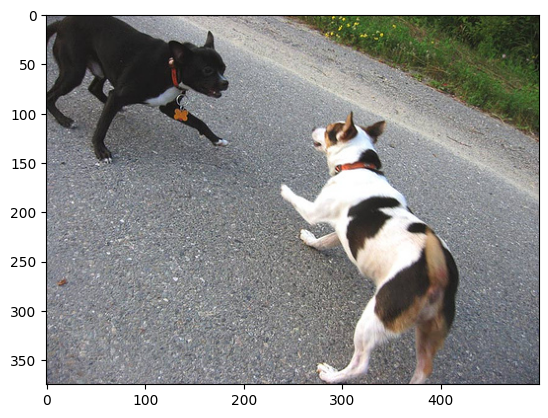

Caption: A black dog and a spotted dog are fighting
Caption: A black dog and a tri-colored dog playing with each other on the road .
Caption: A black dog and a white dog with brown spots are staring at each other in the street .
Caption: Two dogs of different breeds looking at each other on the road .
Caption: Two dogs on pavement moving toward each other .


In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#select any index from the whole dataset 
#single image has 5 captions
#so, select indx as: 1,6,11,16...
data_idx =5

#eg path to be plot: ../input/flickr8k/Images/1000268201_693b08cb0e.jpg
image_path = data_location+"/Images/"+df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx 
for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])

In [33]:
#imports 
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from PIL import Image
#using spacy for the better text tokenization 
spacy_eng = spacy.load("en_core_web_sm")

#example
text = "My laptop isn't working"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['my', 'laptop', 'is', "n't", 'working']

In [34]:
class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    

In [35]:
#testing the vicab class 
v = Vocabulary(freq_threshold=3)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [36]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5, data_limit=1000):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)[:data_limit]
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [37]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [38]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

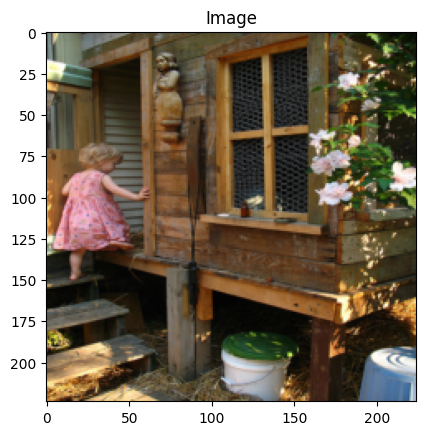

Token: tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [40]:
#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms,
    data_limit=len(df)
)



img, caps = dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [41]:
#splitting the dataset to train test and val
from torch.utils.data import random_split

# Define the lengths for the splits (e.g., 80% train, 10% validation, 10% test)
data_size = len(dataset)
train_size = int(0.8 * data_size)
val_size = int(0.1 * data_size)
test_size = data_size - train_size - val_size  # Ensures no data is lost

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [42]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [43]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 16
NUM_WORKER = 0

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

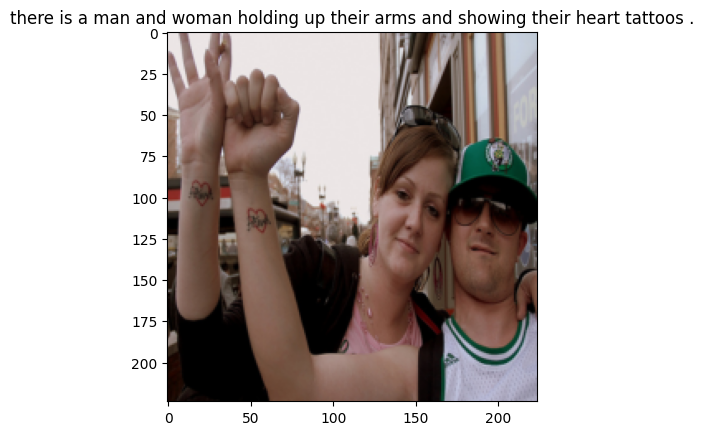

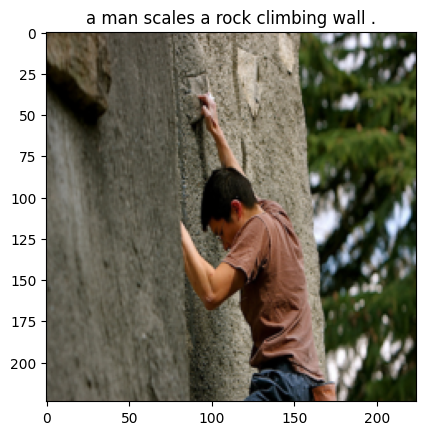

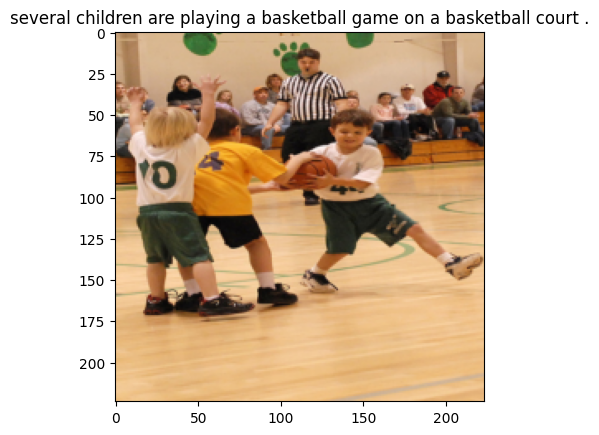

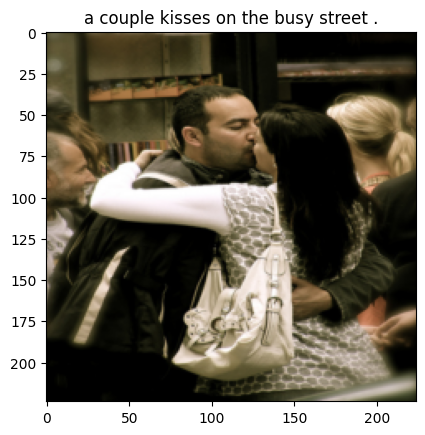

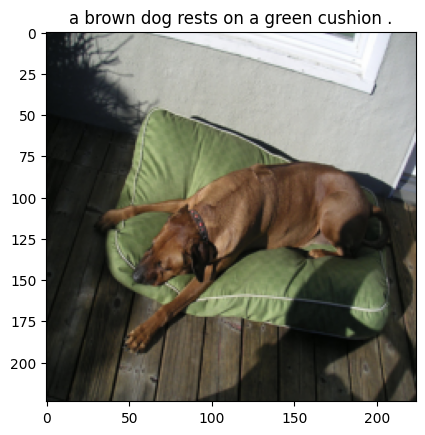

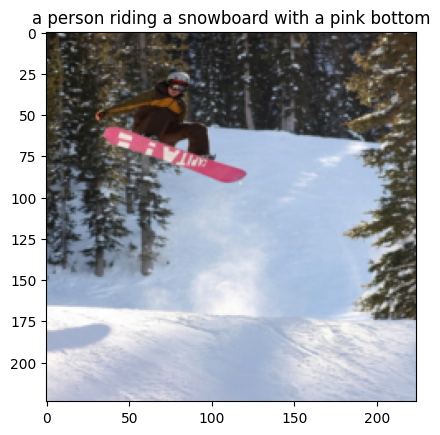

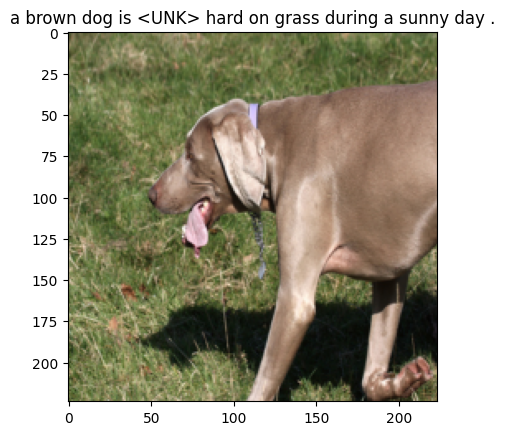

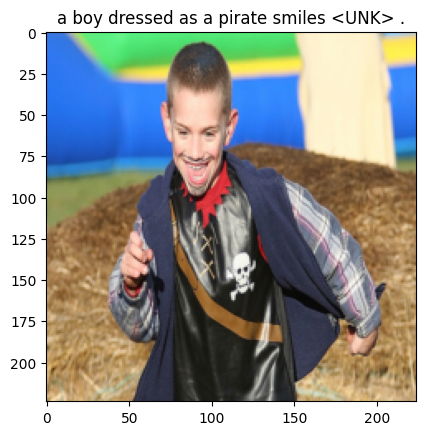

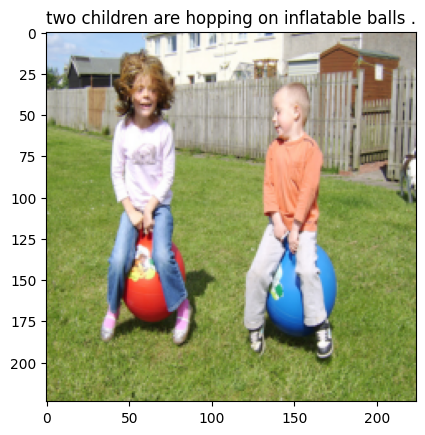

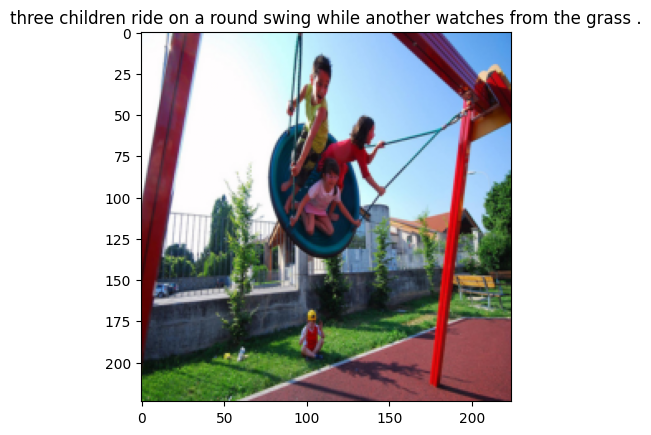

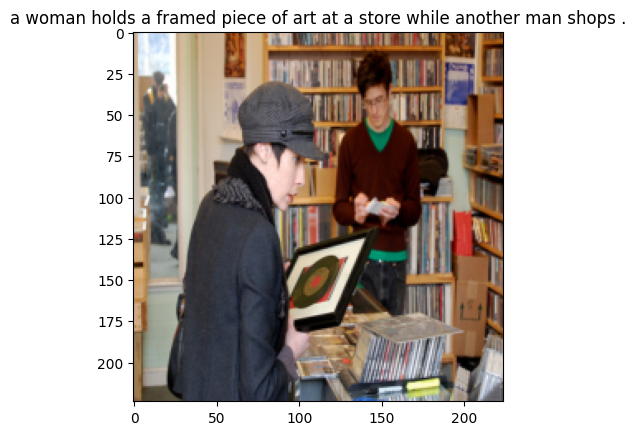

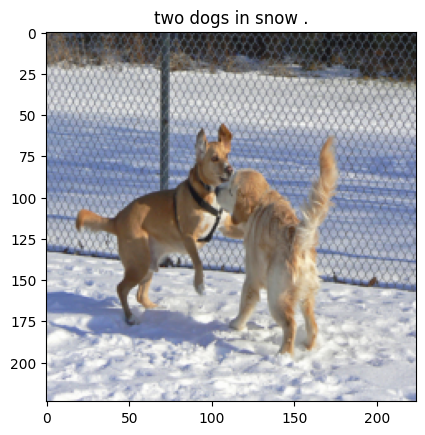

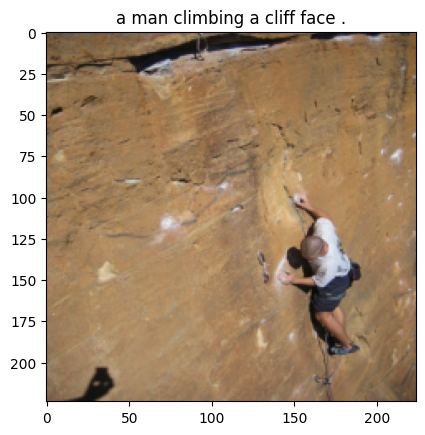

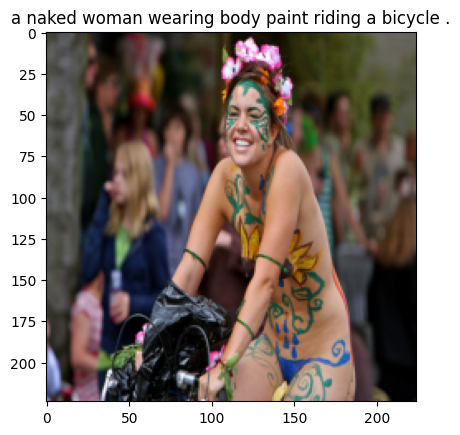

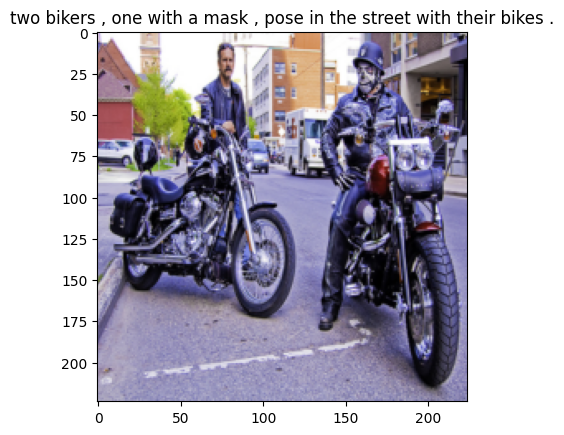

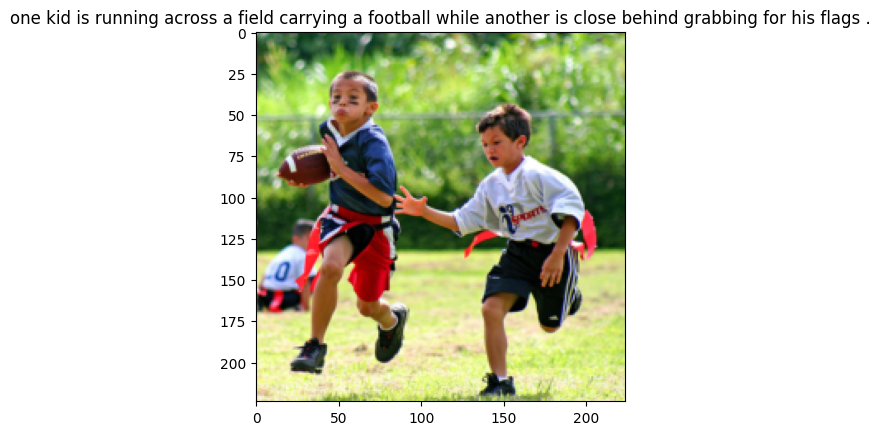

In [44]:
#generating the iterator from the dataloader
dataiter = iter(train_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

<h1>Model architecture</h1>

after preparing the data, we now want to build the model and the training function 

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features
        

In [6]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        

In [7]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [8]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


<h2>Setting Hypperparameter and Init the model</h2>

In [46]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [47]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

D:\Anaconda\envs\test\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\test\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

<h2>Training chatgpt</h2>

In [49]:
from tqdm import tqdm
import numpy as np

# Early stopping parameters
patience = 3
best_val_loss = np.inf
epochs_no_improve = 0

num_epochs = 25
print_every = 20

for epoch in range(1, num_epochs + 1):
    model.train()  # Ensure the model is in training mode
    train_loss = 0  # To track cumulative training loss

    # Create a progress bar for training
    train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs} [Training]")

    for idx, (image, captions) in train_bar:
        image, captions = image.to(device), captions.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs, attentions = model(image, captions)

        # Calculate batch loss
        targets = captions[:, 1:]  # Exclude <SOS>
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Update tqdm description
        train_bar.set_postfix(loss=loss.item())

    # Average training loss for the epoch
    train_loss /= len(train_loader)
    print(f"Epoch: {epoch}, Average Training Loss: {train_loss:.5f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0

    # Create a progress bar for validation
    val_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Epoch {epoch}/{num_epochs} [Validation]")

    with torch.no_grad():
        for idx, (image, captions) in val_bar:
            image, captions = image.to(device), captions.to(device)

            # Forward pass
            outputs, attentions = model(image, captions)

            # Calculate loss
            targets = captions[:, 1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

            val_loss += loss.item()

            # Update tqdm description
            val_bar.set_postfix(loss=loss.item())

    # Average validation loss for the epoch
    val_loss /= len(val_loader)
    print(f"Epoch: {epoch}, Validation Loss: {val_loss:.5f}")

    # Check early stopping criteria
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        print("Validation loss improved. Saving model...")
        save_model(model, epoch)  # Save model if validation loss improves
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("Early stopping triggered. Training stopped.")
            break


Epoch 1/25 [Training]: 100%|████████████████████████████████████████████| 2023/2023 [18:29<00:00,  1.82it/s, loss=3.22]


Epoch: 1, Average Training Loss: 3.63007


Epoch 1/25 [Validation]: 100%|████████████████████████████████████████████| 253/253 [01:43<00:00,  2.45it/s, loss=3.51]


Epoch: 1, Validation Loss: 3.11124
Validation loss improved. Saving model...


Epoch 2/25 [Training]: 100%|█████████████████████████████████████████████| 2023/2023 [17:16<00:00,  1.95it/s, loss=2.9]


Epoch: 2, Average Training Loss: 2.98504


Epoch 2/25 [Validation]: 100%|████████████████████████████████████████████| 253/253 [01:42<00:00,  2.48it/s, loss=2.76]


Epoch: 2, Validation Loss: 2.84140
Validation loss improved. Saving model...


Epoch 3/25 [Training]: 100%|████████████████████████████████████████████| 2023/2023 [17:19<00:00,  1.95it/s, loss=3.18]


Epoch: 3, Average Training Loss: 2.75576


Epoch 3/25 [Validation]: 100%|████████████████████████████████████████████| 253/253 [01:44<00:00,  2.42it/s, loss=2.45]


Epoch: 3, Validation Loss: 2.70280
Validation loss improved. Saving model...


Epoch 4/25 [Training]: 100%|████████████████████████████████████████████| 2023/2023 [18:11<00:00,  1.85it/s, loss=2.65]


Epoch: 4, Average Training Loss: 2.61002


Epoch 4/25 [Validation]: 100%|████████████████████████████████████████████| 253/253 [02:12<00:00,  1.90it/s, loss=2.99]


Epoch: 4, Validation Loss: 2.62333
Validation loss improved. Saving model...


Epoch 5/25 [Training]: 100%|████████████████████████████████████████████| 2023/2023 [24:45<00:00,  1.36it/s, loss=2.77]


Epoch: 5, Average Training Loss: 2.50014


Epoch 5/25 [Validation]: 100%|████████████████████████████████████████████| 253/253 [02:07<00:00,  1.99it/s, loss=2.56]


Epoch: 5, Validation Loss: 2.57058
Validation loss improved. Saving model...


Epoch 6/25 [Training]: 100%|████████████████████████████████████████████| 2023/2023 [20:25<00:00,  1.65it/s, loss=2.65]


Epoch: 6, Average Training Loss: 2.41609


Epoch 6/25 [Validation]: 100%|████████████████████████████████████████████| 253/253 [01:42<00:00,  2.46it/s, loss=2.31]


Epoch: 6, Validation Loss: 2.52908
Validation loss improved. Saving model...


Epoch 7/25 [Training]: 100%|████████████████████████████████████████████| 2023/2023 [17:14<00:00,  1.96it/s, loss=2.45]


Epoch: 7, Average Training Loss: 2.34121


Epoch 7/25 [Validation]: 100%|████████████████████████████████████████████| 253/253 [01:42<00:00,  2.47it/s, loss=2.51]


Epoch: 7, Validation Loss: 2.49576
Validation loss improved. Saving model...


Epoch 8/25 [Training]: 100%|████████████████████████████████████████████| 2023/2023 [17:09<00:00,  1.97it/s, loss=2.54]


Epoch: 8, Average Training Loss: 2.27498


Epoch 8/25 [Validation]: 100%|████████████████████████████████████████████| 253/253 [01:42<00:00,  2.47it/s, loss=2.78]


Epoch: 8, Validation Loss: 2.48055
Validation loss improved. Saving model...


Epoch 9/25 [Training]: 100%|████████████████████████████████████████████| 2023/2023 [17:10<00:00,  1.96it/s, loss=2.71]


Epoch: 9, Average Training Loss: 2.21783


Epoch 9/25 [Validation]: 100%|████████████████████████████████████████████| 253/253 [01:41<00:00,  2.50it/s, loss=2.99]


Epoch: 9, Validation Loss: 2.46068
Validation loss improved. Saving model...


Epoch 10/25 [Training]: 100%|████████████████████████████████████████████| 2023/2023 [17:09<00:00,  1.96it/s, loss=2.3]


Epoch: 10, Average Training Loss: 2.16433


Epoch 10/25 [Validation]: 100%|████████████████████████████████████████████| 253/253 [01:42<00:00,  2.47it/s, loss=2.2]


Epoch: 10, Validation Loss: 2.44784
Validation loss improved. Saving model...


Epoch 11/25 [Training]: 100%|███████████████████████████████████████████| 2023/2023 [17:09<00:00,  1.96it/s, loss=1.84]


Epoch: 11, Average Training Loss: 2.11558


Epoch 11/25 [Validation]: 100%|███████████████████████████████████████████| 253/253 [01:42<00:00,  2.47it/s, loss=2.18]


Epoch: 11, Validation Loss: 2.44793
No improvement in validation loss for 1 epochs.


Epoch 12/25 [Training]: 100%|███████████████████████████████████████████| 2023/2023 [17:25<00:00,  1.93it/s, loss=1.85]


Epoch: 12, Average Training Loss: 2.07241


Epoch 12/25 [Validation]: 100%|████████████████████████████████████████████| 253/253 [01:42<00:00,  2.47it/s, loss=2.5]


Epoch: 12, Validation Loss: 2.44204
Validation loss improved. Saving model...


Epoch 13/25 [Training]: 100%|███████████████████████████████████████████| 2023/2023 [18:40<00:00,  1.81it/s, loss=2.46]


Epoch: 13, Average Training Loss: 2.02950


Epoch 13/25 [Validation]: 100%|███████████████████████████████████████████| 253/253 [01:44<00:00,  2.42it/s, loss=2.14]


Epoch: 13, Validation Loss: 2.43786
Validation loss improved. Saving model...


Epoch 14/25 [Training]: 100%|██████████████████████████████████████████████| 2023/2023 [17:20<00:00,  1.95it/s, loss=2]


Epoch: 14, Average Training Loss: 1.99313


Epoch 14/25 [Validation]: 100%|███████████████████████████████████████████| 253/253 [01:40<00:00,  2.53it/s, loss=2.65]


Epoch: 14, Validation Loss: 2.43189
Validation loss improved. Saving model...


Epoch 15/25 [Training]: 100%|███████████████████████████████████████████| 2023/2023 [17:09<00:00,  1.97it/s, loss=2.06]


Epoch: 15, Average Training Loss: 1.95307


Epoch 15/25 [Validation]: 100%|███████████████████████████████████████████| 253/253 [01:43<00:00,  2.44it/s, loss=2.39]


Epoch: 15, Validation Loss: 2.43421
No improvement in validation loss for 1 epochs.


Epoch 16/25 [Training]: 100%|███████████████████████████████████████████| 2023/2023 [17:07<00:00,  1.97it/s, loss=2.05]


Epoch: 16, Average Training Loss: 1.92029


Epoch 16/25 [Validation]: 100%|███████████████████████████████████████████| 253/253 [01:42<00:00,  2.48it/s, loss=2.19]


Epoch: 16, Validation Loss: 2.42837
Validation loss improved. Saving model...


Epoch 17/25 [Training]: 100%|███████████████████████████████████████████| 2023/2023 [17:14<00:00,  1.96it/s, loss=2.08]


Epoch: 17, Average Training Loss: 1.88574


Epoch 17/25 [Validation]: 100%|███████████████████████████████████████████| 253/253 [01:42<00:00,  2.47it/s, loss=2.66]


Epoch: 17, Validation Loss: 2.44017
No improvement in validation loss for 1 epochs.


Epoch 18/25 [Training]: 100%|███████████████████████████████████████████| 2023/2023 [17:14<00:00,  1.95it/s, loss=1.68]


Epoch: 18, Average Training Loss: 1.85646


Epoch 18/25 [Validation]: 100%|███████████████████████████████████████████| 253/253 [01:43<00:00,  2.46it/s, loss=2.18]


Epoch: 18, Validation Loss: 2.44174
No improvement in validation loss for 2 epochs.


Epoch 19/25 [Training]: 100%|████████████████████████████████████████████| 2023/2023 [17:12<00:00,  1.96it/s, loss=1.8]


Epoch: 19, Average Training Loss: 1.82414


Epoch 19/25 [Validation]: 100%|███████████████████████████████████████████| 253/253 [01:43<00:00,  2.44it/s, loss=2.42]

Epoch: 19, Validation Loss: 2.44805
No improvement in validation loss for 3 epochs.
Early stopping triggered. Training stopped.


<h3>saving model again</h3>

In [50]:
#helper function to save the model
def save_model2(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state_final.pth')

In [51]:
save_model2(model,num_epochs)

<h3>visualizing the attention</h3>

In [52]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

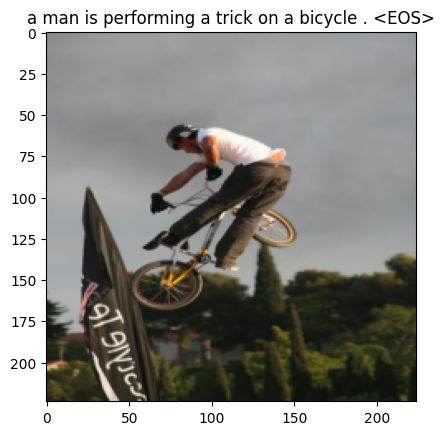

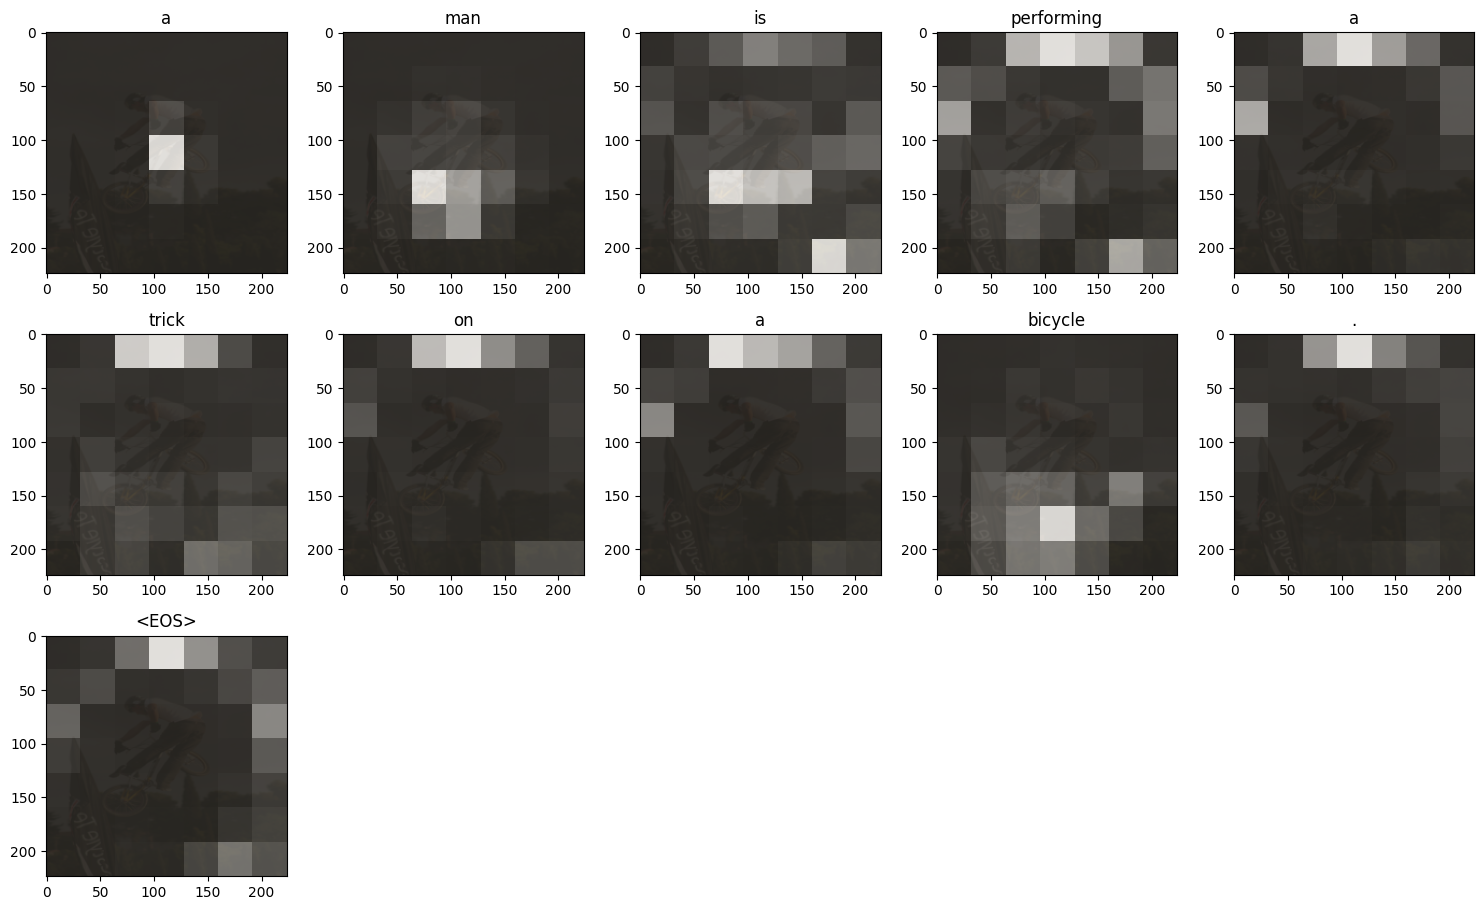

In [53]:
#show any 1
dataiter_test = iter(test_loader)
images,_ = next(dataiter_test)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

<h2>Testing Performance on the Test data</h2>

In [54]:
def evaluate_test_loss(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0  # Initialize cumulative test loss
    total_batches = len(test_loader)

    with torch.no_grad():  # Disable gradient calculation
        for images, captions in tqdm(test_loader, desc="Testing"):
            # Move data to the appropriate device
            images, captions = images.to(device), captions.to(device)

            # Forward pass
            outputs, _ = model(images, captions)

            # Calculate loss
            targets = captions[:, 1:]  # Exclude <SOS> token
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.reshape(-1))
            test_loss += loss.item()

    # Average test loss
    avg_test_loss = test_loss / total_batches
    print(f"Test Loss: {avg_test_loss:.5f}")

    return avg_test_loss

In [55]:
# Assuming you have already defined `test_loader`, `criterion`, and `device`
test_loss = evaluate_test_loss(model, test_loader, criterion, device)

Testing: 100%|███████████████████████████████████████████████████████████████████████| 253/253 [02:21<00:00,  1.78it/s]

Test Loss: 2.43973


<h2>Finding out the BLEU score 🔍</h2>

In [57]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

def calculate_bleu_score(model, test_loader, dataset, device):
    model.eval()  # Set the model to evaluation mode
    references = []  # List to store all reference captions
    hypotheses = []  # List to store all generated captions

    with torch.no_grad():
        for images, captions in tqdm(test_loader, desc="Evaluating BLEU Score"):
            # Move images to the appropriate device
            images = images.to(device)

            # Generate captions for the images
            for idx in range(images.size(0)):  # Process batch one image at a time
                features = model.encoder(images[idx:idx+1])
                generated_caption, _ = model.decoder.generate_caption(features, vocab=dataset.vocab)
                
                # Add the generated caption to hypotheses
                hypotheses.append(generated_caption)

                # Get the reference captions for this image
                ref_idx = test_loader.dataset.indices[idx]
                reference_caption = dataset.df.loc[ref_idx, "caption"]
                
                # Add to references (wrap single reference in a list for BLEU)
                references.append([reference_caption.split()])

    # Calculate BLEU score
    bleu_score = corpus_bleu(references, hypotheses)
    print(f"BLEU Score: {bleu_score:.4f}")

    return bleu_score

In [58]:
bleu_score = calculate_bleu_score(model, test_loader, dataset, device)

Evaluating BLEU Score: 100%|█████████████████████████████████████████████████████████| 253/253 [03:37<00:00,  1.16it/s]


BLEU Score: 0.0073


<h1>Loading a Pretrained model and comparing it to ours in terms of the BLEU score</h1>

In [59]:
import torch
from PIL import Image
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import os
import IPython.display as display

In [60]:
model = VisionEncoderDecoderModel.from_pretrained('nlpconnect/vit-gpt2-image-captioning')
feature_extractor= ViTImageProcessor.from_pretrained('nlpconnect/vit-gpt2-image-captioning')
tokenizer= AutoTokenizer.from_pretrained('nlpconnect/vit-gpt2-image-captioning')

D:\Anaconda\envs\test\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [61]:
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [101]:
import torch
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
device= 'cuda' if torch.cuda.is_available() else 'cpu'
def calculate_bleu_pretrained_model(model, feature_extractor, tokenizer, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    myvocab= dataset.vocab
    references = []  # List to store ground truth captions
    hypotheses = []  # List to store model-generated captions

    with torch.no_grad():
        for images, captions in tqdm(test_loader, desc="Evaluating BLEU Score"):
                
            # Preprocess images using feature extractor
            pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
            pixel_values = pixel_values.to(device)

            # Generate captions
            output_ids = model.generate(pixel_values, max_length=16, num_beams=4)
            generated_captions = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

            # Add generated captions to hypotheses
            for gen_caption in generated_captions:
                hypotheses.append(gen_caption.split())  # Tokenize generated caption
        
            # Decode ground truth captions from tokens
            for caption_tensor in captions:
                decoded_caption = [
                    myvocab.itos[token] for token in caption_tensor.tolist() if token not in [myvocab.stoi["<SOS>"], myvocab.stoi["<EOS>"], myvocab.stoi["<PAD>"]]
                ]
                references.append([decoded_caption])  # Wrap in list for BLEU

    # Calculate BLEU score
    bleu_score = corpus_bleu(references, hypotheses)
    print(f"BLEU Score: {bleu_score:.4f}")

    return bleu_score

<h3>optimizing the code a bit</h3>

In [103]:
def calculate_bleu_pretrained_model_optimized(model, feature_extractor, tokenizer, test_loader, vocab, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)

    references = []  # List to store ground truth captions
    hypotheses = []  # List to store model-generated captions

    with torch.no_grad():
        for images, captions in tqdm(test_loader, desc="Evaluating BLEU Score"):
            # Preprocess images
            pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values.to(device)

            # Generate captions with reduced beams
            output_ids = model.generate(pixel_values, max_length=16, num_beams=1)
            generated_captions = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

            # Add generated captions to hypotheses
            hypotheses.extend([gen_caption.split() for gen_caption in generated_captions])

            # Decode ground truth captions
            for caption_tensor in captions:
                decoded_caption = [
                    vocab.itos[token] for token in caption_tensor.tolist() if token not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]]
                ]
                references.append([decoded_caption])  # Wrap in list for BLEU

    # Calculate BLEU score
    bleu_score = corpus_bleu(references, hypotheses)
    print(f"BLEU Score: {bleu_score:.4f}")

    return bleu_score


In [107]:
print(f'the device is {device}');
print('evaluation has started')
# Call the BLEU score calculation function
bleu_score = calculate_bleu_pretrained_model_optimized(model, feature_extractor, tokenizer, test_loader, vocab= dataset.vocab, device=device)

the device is cuda
evaluation has started


Evaluating BLEU Score: 100%|███████████████████████████████████████████████████████| 253/253 [4:58:11<00:00, 70.72s/it]


BLEU Score: 0.0000


D:\Anaconda\envs\test\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [108]:
bleu_score

1.9271597571434985e-79

In [119]:
from torchvision.transforms import ToPILImage
#let us check the prediction of this model on a random image in the test loader 
iter_test = iter(test_loader)
batch = next(iter_test)
images,captions =batch 
#this is a tensor images[0] so let us convert it to an image and show it 
# Use ToPILImage to convert the tensor to a PIL image
to_pil = ToPILImage()
image = to_pil(images[5])


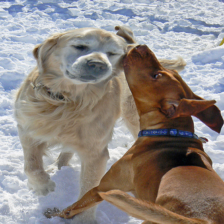

In [120]:
image

In [115]:
#pass it to the model? 


In [121]:
pixel_values = feature_extractor(images=images[0], return_tensors="pt").pixel_values.to(device)

In [122]:
output_ids = model.generate(pixel_values, max_length=16, num_beams=1)
generated_captions = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

In [123]:
generated_captions

['a blurry photo of a street scene with a light ']

<h2>Retrieving our model and eval it on the same pic above</h2>

In [125]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

#init model
mymodel = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

D:\Anaconda\envs\test\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\test\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [126]:
import torch

# Assume the model's class definitions (Encoder, Decoder) are already available

# Load the model state
checkpoint = torch.load('attention_model_state_final.pth')

# Retrieve saved parameters
num_epochs = checkpoint['num_epochs']
embed_size = checkpoint['embed_size']
vocab_size = checkpoint['vocab_size']
attention_dim = checkpoint['attention_dim']
encoder_dim = checkpoint['encoder_dim']
decoder_dim = checkpoint['decoder_dim']

 
mymodel.load_state_dict(checkpoint['state_dict'])
 
mymodel.eval().to(device)

C:\Users\mfaki\AppData\Local\Temp\ipykernel_13520\1363081439.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('attention_model_state_final.pth')


EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

In [129]:
#add the batch dimension 
my_batch = images[0].unsqueeze(0)

In [130]:
my_batch.shape

torch.Size([1, 3, 224, 224])

In [132]:
#generate caption
def get_caps_from(features_tensors, model=mymodel):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

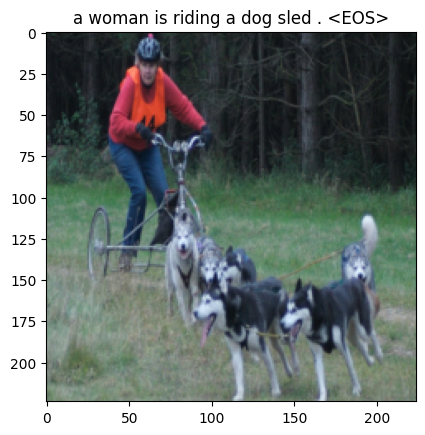

In [133]:
img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

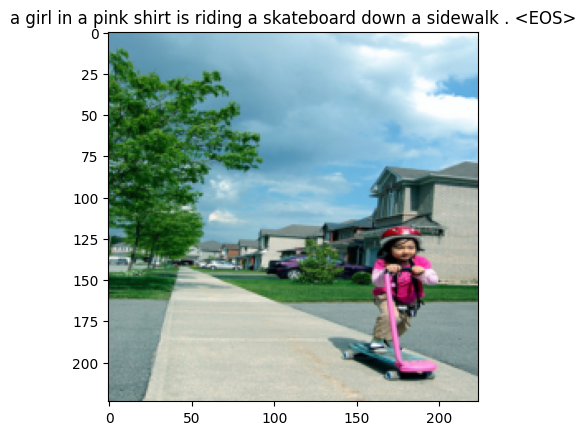

In [134]:
img = images[1].detach().clone()
img1 = images[1].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))